## tFBA with metabolomic constraints

This notebook illustrates how the functions from the Thermo module can be used to create a tFBA-ready model, constrain it with metabolomic data, relax its bounds, and obtain a solution.

Import Thermo module.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from BFAIR import thermo, thermo_models

Using license file C:\Users\riheme\gurobi.lic
Academic license - for non-commercial use only


Load thermodynamic information and create model.

In [2]:
tmodel = thermo_models.iJO1366

Read LP format model from file C:\Users\riheme\AppData\Local\Temp\tmp3se702dr.lp
Reading time = 0.02 seconds
: 1807 rows, 5170 columns, 20334 nonzeros
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter Method unchanged
   Value: 0  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1


2020-12-09 18:51:14,089 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2020-12-09 18:51:14,099 - thermomodel_None - INFO - # Model preparation starting...
2020-12-09 18:51:16,813 - thermomodel_None - WARNING - Warning : NULL/U
2020-12-09 18:51:16,813 - thermomodel_None - WARNING - Warning : NULL/L
2020-12-09 18:51:16,813 - thermomodel_None - WARNING - Warning : NULL/L
2020-12-09 18:51:16,813 - thermomodel_None - WARNING - Warning : NULL/U
2020-12-09 18:51:16,813 - thermomodel_None - WARNING - Warning : NULL/L
2020-12-09 18:51:16,813 - thermomodel_None - WARNING - Warning : NULL/L
2020-12-09 18:51:17,065 - thermomodel_None - WARNING - Warning : NULL/U
2020-12-09 18:51:17,065 - thermomodel_None - WARNING - Warning : NULL/L
2020-12-09 18:51:17,065 - thermomodel_None - WARNING - Warning : NULL/L
2020-12-09 18:51:17,065 - thermomodel_None - WARNING - Warning : NULL/U
2020-12-09 18:51:17,065 - thermomodel_None - WARNING - Warning : NULL/L
2020-12

Load and apply reaction and log concentration bounds.

In [3]:
bounds = pd.read_csv('../tests/test_data/test_bounds.csv')

rxn_bounds = bounds[bounds['bound_type'] == 'flux']
lc_bounds = bounds[bounds['bound_type'] == 'log_concentration']

thermo.adjust_model(tmodel, rxn_bounds, lc_bounds)

bounds.head()

,id,lb,ub,bound_type
0,DM_ac_e,7.99,15.84,flux
1,DM_glc_e,-22.30,-11.90,flux
2,Ec_biomass_iJO1366_WT_53p95M,0.87,0.98,flux
3,ATPM,3.15,3.15,flux
4,6pgc,-8.76,-8.46,log_concentration


Attempt optimization.

In [4]:
tmodel.slim_optimize()
if tmodel.solver.status == 'infeasible':
    print('MILP problem requires relaxation.')

MILP problem requires relaxation.


Relax log concentration bounds.

In [5]:
relax_table = thermo.relax_lc(tmodel)
relax_table

,bound_change,compartment
metabolite,,
2p4c2me_c,21.648723,Cytosol
5caiz_c,4.361519,Cytosol
acon-C_c,-4.600303,Cytosol
adp_c,-6.470005,Cytosol
adphep-LD_c,3.377868,Cytosol
air_c,-2.563704,Cytosol
arg-L_c,-14.480262,Cytosol
cmp_c,-2.142947,Cytosol
gagicolipa_c,-58.481047,Cytosol


Obtain calculated Gibbs free energy.

In [6]:
delta_g = thermo.get_delta_g(tmodel)
delta_g.head()

,delta_g,subsystem
reaction,,
12DGR120tipp,7.807372,"Transport, Inner Membrane"
12DGR140tipp,9.355502,"Transport, Inner Membrane"
12DGR141tipp,8.581437,"Transport, Inner Membrane"
12DGR160tipp,10.903633,"Transport, Inner Membrane"
12DGR161tipp,14.960752,"Transport, Inner Membrane"


Plot Gibbs free energy.

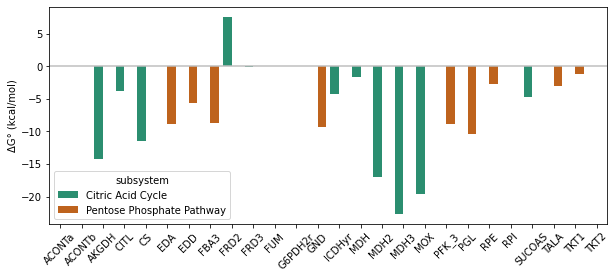

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_mask = delta_g['subsystem'].isin(['Citric Acid Cycle', 'Pentose Phosphate Pathway'])

sns.barplot(
    ax= ax,
    data=delta_g[plot_mask].reset_index(),
    y='delta_g', x='reaction', hue='subsystem', palette='Dark2'
)

ax.set_ylabel('ΔG° (kcal/mol)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=0, c='.75')